<a href="https://colab.research.google.com/github/carlocamilloni/Structural-Bioinformatics/blob/main/Notebooks/lab02b_MDanalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Trajectory Analysis using MDanalysis

##Theoretical Aspects

Now that you have already generated a molecular dynamics trajectory in the previous tutorial, it is crucial to obtain quantifiable insights about your molecular system. There are a handfull of metrics that can be employed to achieve this, here we are going to focus on two of the most popular ones. RMSD and RMSF and distances.

### ***Root Mean Square Deviation (RMSD)*** overview

$RMSD$ measures the deviation of a target set of coordinates (i.e. a structure) to a reference set of coordinates, with $RMSD=0$ indicating a perfect overlap. 
Then it follows that if we have a MD trajectory one would expect that the lower the RMSD the less changes happen in the time scale studied. 

RMSD is defined as:

<center>
<font size="5">
$RMSD = \sqrt{\frac{\sum_{i = 0}^N m_i(X_i - Y_i)^2}{M}}$
</font>
</center>


 Where **N** is the number of atoms,  $m_{i}$ is the mass of atom $i$, $X_i$ is the coordinate vector for target atom $i$, $Y_i$ is the coordinate vector for reference atom $i$, and $M$ is the total mass. If the $RMSD$ is not mass-weighted, for all $i$, $m_i = 1$, and $M = N$.
When calculating $RMSD$ of a target to reference structure, there are two very important requirements as we will see soon in the practical part of this tutorial:

1. The number of atoms in the target must match the number of atoms in the reference.
2. The ordering of atoms in the target must match the ordering of atoms in the reference.



### ***Root Mean Square Fluctuation (RMSF)*** overview

As mentioned in the [MDanalysis user guide ](https://userguide.mdanalysis.org/stable/examples/analysis/alignment_and_rms/rmsf.html):

> The root-mean-square-fluctuation ($RMSF$) of a structure is **the time average of the RMSD**. It is calculated according to the below equation, where $x_i$
 is the coordinates of particle $i$ and $⟨x_i⟩$ is the ensemble average position of $i$:


<center> 
<font size="5">
$ ρ_i=\sqrt{⟨(x_i−⟨x_i⟩)^2⟩}$
</font>
</center>


> Where the $RMSD$ quantifies how much a structure diverges from a reference over time, the **$RSMF$ can reveal which areas of the system are the most mobile**. While $RMSD$ is frequently calculated to an initial state, the RMSF should be calculated to an average structure of the simulation. An area of the structure with high $RMSF$ values frequently diverges from the average, indicating high mobility. When $RMSF$ analysis is carried out on proteins, it is typically restricted to backbone or alpha-carbon atoms; these are more characteristic of conformational changes than the more flexible side-chains.

<figure>
<center>
<img src='https://www.frontiersin.org/files/Articles/329304/fphar-09-00492-HTML/image_m/fphar-09-00492-g002.jpg'/>
<figcaption>FIGURE 2. RMSD and RMSF plots of the structural changes occuring due to antagonist binding in the ligand binding pocket of androgen receptor, elucidated through MD simulations.<br>Sugunadevi S et al (2018)<i> Front Pharmacology 9, 492</i> </figcaption></center>
</figure>

### Distances
As you may recall trajectory files stores the position of each individual atoms, the calculation of distances through an MD simulation is usually really straightforward.



### MDanalysis package overview 

As defined in the [documentation](https://docs.mdanalysis.org/stable/documentation_pages/overview.html): 
> **MDAnalysis** is a Python package that provides classes to access data in molecular dynamics trajectories. It is object oriented so it treats atoms, groups of atoms, trajectories, etc as different objects. Each object has a number of operations defined on itself (also known as “methods”) and also contains values describing the object (“attributes”). For example, a **AtomGroup** object has a **center_of_mass()** method that returns the center of mass of the group of atoms. It also contains an attribute called residues that lists all the residues that belong to the group. Using methods such as **select_atoms()** (which uses CHARMM-style atom Selection commands) one can create new objects (in this case, another **AtomGroup**).

Example of MDanalysis code 
A typical usage pattern is to iterate through a trajectory and analyze coordinates for every frame. In the following example the end-to-end distance of a protein and the radius of gyration of the backbone atoms are calculated:






```
#!pip3 install --upgrade MDAnalysis
#!pip install --upgrade MDAnalysisTests
import MDAnalysis
from MDAnalysis.tests.datafiles import PSF,DCD  # test trajectory
import numpy.linalg
u = MDAnalysis.Universe(PSF,DCD)  # always start with a Universe
nterm = u.select_atoms('segid 4AKE and name N')[0]  # can access structure via segid (s4AKE) and atom name
cterm = u.select_atoms('segid 4AKE and name C')[-1]  # ... takes the last atom named 'C'
bb = u.select_atoms('protein and backbone')  # a selection (a AtomGroup)
for ts in u.trajectory:  # iterate through all frames
    r = cterm.pos - nterm.pos  # end-to-end vector from atom positions
    d = numpy.linalg.norm(r)   # end-to-end distance
    rgyr = bb.radius_of_gyration()  # method of a AtomGroup; updates with each frame
    print "frame = %d: d = %f Angstroem, Rgyr = %f Angstroem" % (ts.frame, d, rgyr)
```



### Basic concepts of MD analysis


1.   Universes and atom groups
2.   Selections



**Universe and AtomGroup**

MDAnalysis is object oriented. Molecular systems consist of Atom objects (instances of the class MDAnalysis.core.groups.Atom), which are grouped in AtomGroup instances. You build the AtomGroup of your system by loading a topology (list of atoms and possibly their connectivity) together with a trajectory (coordinate information) into the central data structure, the Universe object:



```
u = MDAnalysis.Universe(PSF, DCD)
print(u)
<Universe with 3341 atoms>
```



**Selections**

MDAnalysis comes with a fairly complete atom selection facility. Primarily, one uses the method select_atoms() of a Universe:



```
>>> CA = u.select_atoms("protein and name CA")
>>> CA
>>> <AtomGroup with 214 atoms>
```


but really any AtomGroup has a select_atoms() method:

```
>>> acidic = CA.select_atoms("resname ASP or resname GLU")
>>> acidic
<AtomGroup with 35 atoms>
>>> list(acidic.residues)
[<Residue GLU, 22>,
 <Residue ASP, 33>,
 <Residue GLU, 44>,
 ...
 <Residue GLU, 210>]
 ```

See also All the selection keywords are described in the documentation.
Numerical ranges can be written as first-last (or equivalently first:last 1), where the range is inclusive. For example, get residues with residue IDs 5 to 100:

```
>>> u.select_atoms("resid 5-100")
<AtomGroup with 1439 atoms>
>>> u.select_atoms("resid 5-100").n_residues
96
```
Selections can be combined with boolean expressions. For example, to select the Cα atoms of all acidic residues [aspartic acid (“ASP”), glutamic acid (“GLU”), and histidines (named “HIS”, “HSD”, or “HSE”, depending on what force field is being used and what protonation state it is in)]:
```
>>> u.select_atoms("(resname ASP or resname GLU or resname HS*) and name CA")
<AtomGroup with 38 atoms>
```
We group with or separate selections by residue name (keyword resname). First either ASP, GLU, or any histidines are selected (we use “stemming” HS* to match any residue name that starts with “HS”). Then only those atoms whose name is “CA” are taken from the first set by an and selection. For convenience, the or in the first part of the selection can be taken implicitly with the shortcut syntax
```
>>> u.select_atoms("resname ASP GLU HS* and name CA")
<AtomGroup with 38 atoms>
```


If you want to dig deeper into the selection syntaxis of MDanalysis you can read the full documentation [here](https://docs.mdanalysis.org/1.0.0/documentation_pages/selections.html)

##Part 0 Downloading and Installing the required software

For this tutorial we are going to use a MD trajectory from DNA binding domain of the HIV integrase 1, as you can see in the PDB [entry](https://www.rcsb.org/structure/1IHV) this structure was solved using NMR, and was found to form a dimer in solution.

Here we are going to analyze 1000 frames of the integrase the monomeric and dimeric states and compare their RMSD, RMSF and measure distances.

<figure>
<center>
<img src='https://cdn.rcsb.org/images/structures/ih/1ihv/1ihv_chain-A.jpeg'/>
<figcaption>FIGURE 3. Cartoon representation of the structure of HIV integrase 1 (PDB 1IHV)</figcaption></center>
</figure>



### Installation

we must install the softwares to perform this tutorial. Namely:
- **MDAnalysis** for analyzing the data in molecular dynamics trajectories.
- **py3Dmol** for visualization of the protein structure.


In [1]:
!pip3 install --upgrade MDAnalysis
# Import MDanalysis
import MDAnalysis as mda
#from MDAnalysis.tests.datafiles import PSF, DCD, DCD2
from MDAnalysis.analysis import gnm
import matplotlib.pyplot as plt
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.5 MB 4.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 2.6 MB 44.7 MB/s 
     |████████████████████████████████| 376 kB 47.4 MB/s 
     |████████████████████████████████| 2.1 MB 54.8 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
  Created wheel for MDAnalysis: filename=MDAnalysis-2.1.0-cp37-cp37m-linux_x86_64.whl size=4649730 sha256=03c8cdee54fa33e1fcac8ae073c228c1e2bbcb572a6cbda92106ed3ec58ccd04
  Stored in directory: /root/.cache/pip/wheels/fa/dd/6b/9d51e7216a401b71949467a123e3b2dffba11256346f7f7bda
Successfully built MDAnalysis


In [2]:
#Installing py3Dmol using pip
!pip install py3Dmol

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#Importing py3Dmol for safety
import py3Dmol

In [4]:
!wget http://www.rcsb.org/pdb/files/1IHV.pdb.gz 
!gunzip 1IHV.pdb.gz

--2022-11-05 15:18:20--  http://www.rcsb.org/pdb/files/1IHV.pdb.gz
Resolving www.rcsb.org (www.rcsb.org)... 128.6.159.248
Connecting to www.rcsb.org (www.rcsb.org)|128.6.159.248|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.rcsb.org/pdb/files/1IHV.pdb.gz [following]
--2022-11-05 15:18:20--  https://www.rcsb.org/pdb/files/1IHV.pdb.gz
Connecting to www.rcsb.org (www.rcsb.org)|128.6.159.248|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://files.rcsb.org/download/1IHV.pdb.gz [following]
--2022-11-05 15:18:20--  https://files.rcsb.org/download/1IHV.pdb.gz
Resolving files.rcsb.org (files.rcsb.org)... 128.6.158.70
Connecting to files.rcsb.org (files.rcsb.org)|128.6.158.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37415 (37K) [application/octet-stream]
Saving to: ‘1IHV.pdb.gz’

1IHV.pdb.gz         100%[===================>]  36.54K  --.-KB/s    in 0.02s   



In [5]:
# We can visualize the dimeric conformation 
view=py3Dmol.view()
view.addModel(open('1IHV.pdb', 'r').read(),'pdb')
#Zooming into all visualized structures 
view.zoomTo()
#Here we set the background color as white
view.setBackgroundColor('white')
#Here we set the visualization style for chain B and C
view.setStyle({'cartoon': {'color':'purple'}})
#And we finally visualize the structures using the command below
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Downloading MD trajectories

In [6]:
#Here we copy to our Colab instance the trajectory files for the monomer and dimer
!wget https://github.com/pb3lab/ibm3202/raw/master/files/md_files/1ihv_dimer_protPBC.xtc
!wget https://github.com/pb3lab/ibm3202/raw/master/files/md_files/1ihv_mon_protPBC.xtc
!wget https://github.com/pb3lab/ibm3202/raw/master/files/md_files/1ihv_mon_protPBC.gro
!wget https://github.com/pb3lab/ibm3202/raw/master/files/md_files/1ihv_dimer_protPBC.gro


--2022-11-05 15:18:21--  https://github.com/pb3lab/ibm3202/raw/master/files/md_files/1ihv_dimer_protPBC.xtc
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pb3lab/ibm3202/master/files/md_files/1ihv_dimer_protPBC.xtc [following]
--2022-11-05 15:18:21--  https://raw.githubusercontent.com/pb3lab/ibm3202/master/files/md_files/1ihv_dimer_protPBC.xtc
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6809220 (6.5M) [application/octet-stream]
Saving to: ‘1ihv_dimer_protPBC.xtc’

1ihv_dimer_protPBC. 100%[===================>]   6.49M  --.-KB/s    in 0.08s   

2022-11-05 15:18:22 (81.0 MB/s) - ‘1ihv_dimer_p

##Part I – Calculating $RMSD$ and $RMSF$

### I.1 - RMSD


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



Please note that the following cells are part of the tutorial of MDanalysis available [here](https://userguide.mdanalysis.org/stable/examples/analysis/alignment_and_rms/aligning_trajectory_to_frame.html) 

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


© Copyright 2019-2020, Lily Wang, Irfan Alibay, Rocco Meli, Mieczyslaw Torchala, Yuxuan Zhuang, Richard J. Gowers, and Oliver Beckstein.





#### I.1A - Calculating $RMSD$ against a reference frame 

In [7]:
import MDAnalysis as mda
from MDAnalysis.analysis import align, rms

First we need to load our trajectory files onto MDanalysis. This is done by creating an instance of an **Universe** object.

In [8]:
#Here we create two Universes each containing the same trajectory of the monomeric trajectory, 
#one called mobile and the other ref which will be used as reference 
mobile = mda.Universe("/content/1ihv_mon_protPBC.gro", "/content/1ihv_mon_protPBC.xtc")
ref = mda.Universe("/content/1ihv_mon_protPBC.gro", "/content/1ihv_mon_protPBC.xtc")

While `align.alignto` aligns single structures, or a frame of a trajectory, `align.AlignTraj` efficiently aligns an entire trajectory to a reference.

We first check the $RMSD$ of our unaligned trajectory so we can compare results later. The code below sets the `mobile` trajectory to the last frame by indexing the last timestep, `ref` to the first frame by indexing the first timestep, and computes the root mean squared deviation between the $\alpha$-carbon positions.

In [9]:
mobile.trajectory[-1]  # set mobile trajectory to last frame
ref.trajectory[0]  # set reference trajectory to first frame

mobile_ca = mobile.select_atoms('name CA')
ref_ca = ref.select_atoms('name CA')
rms.rmsd(mobile_ca.positions, ref_ca.positions, superposition=False)

12.53863354912546

Now we can align the trajectory. We have already set ref to the first frame. In the cell below, we load the positions of the trajectory into memory so we can modify the trajectory in Python.

In [10]:
aligner = align.AlignTraj(mobile, ref, select='name CA', in_memory=True).run()

In [11]:
mobile.trajectory[-1]  # set mobile trajectory to last frame
ref.trajectory[0]  # set reference trajectory to first frame

mobile_ca = mobile.select_atoms('name CA')
ref_ca = ref.select_atoms('name CA')
rms.rmsd(mobile_ca.positions, ref_ca.positions, superposition=False)

2.075469823276649

**QUESTION❓:** How much does the RMSD before and after alignment compare? 

#### I.1B - RMSD of a Universe with multiple selections over time

It is more efficient to use the MDAnalysis.analysis.rms.RMSD class to calculate the $RMSD$ of an entire trajectory to a single reference point.

The rms.RMSD class first performs a rotational and translational alignment of the target trajectory to the reference universe at ref_frame, using the atoms in select to determine the transformation. Then, without further alignment, the RMSD of each group in the `groupselections` argument is calculated.

[Source](https://userguide.mdanalysis.org/stable/examples/analysis/alignment_and_rms/rmsd.html)

In [12]:
#Here we create two Universes each containing the same trajectory of the monomeric trajectory, 
#one called mobile and the other ref which will be used as reference 
monomer_mobile = mda.Universe("/content/1ihv_mon_protPBC.gro", "/content/1ihv_mon_protPBC.xtc")
monomer_ref = mda.Universe("/content/1ihv_mon_protPBC.gro", "/content/1ihv_mon_protPBC.xtc")

In [13]:
rms.rmsd(monomer_mobile.select_atoms('backbone').positions,  # coordinates to align
         monomer_ref.select_atoms('backbone').positions,  # reference coordinates
         center=True,  # subtract the center of geometry
         superposition=True)  # superimpose coordinates

0.0

In [14]:
# Here we define two 
Loop1 = 'backbone and resid 227-240'
Loop2 = 'backbone and resid 252-257'

In [15]:
#Here we calculate the RMSD
R_rmsd = rms.RMSD(mobile,  # universe to align
             ref,  # reference universe or atomgroup
             select='backbone',  # group to superimpose and calculate RMSD
             groupselections=[Loop1, Loop2],  # groups for RMSD
             ref_frame=0)  # frame index of the reference
R_rmsd.run()

The data is saved in R_rmsd.results.rmsd as an array. We can check the dimensions of the array using the *shape* attribute. 

In [16]:
R_rmsd.results.rmsd.shape

(1001, 5)

The variable `R_rmsd.results.rmsd` has a row for each timestep. The first two columns of each row are the frame index of the time step, and the time (which is guessed in trajectory formats without timesteps). The third column is $RMSD$ of the `select` argument. The last few columns are the $RMSD$ of the groups in `groupselections`.

##### Plotting the data

We can easily plot this data using the common data analysis package pandas. We turn the `R_rmsd.results.rmsd` array into a DataFrame and label each column below.

In [17]:
import pandas as pd
df_rmsd_mono = pd.DataFrame(R_rmsd.results.rmsd,
                  columns=['Frame', 'Time (ns)','Backbone','Loop1','Loop2'])

df_rmsd_mono

,Frame,Time (ns),Backbone,Loop1,Loop2
0,0.0,0.0,0.000000,0.000000,0.000000
1,1.0,20.0,1.027202,1.303960,1.022052
2,2.0,40.0,1.034643,1.208177,0.949492
3,3.0,60.0,1.368527,1.355505,1.808766
4,4.0,80.0,1.215353,1.305222,1.369099
...,...,...,...,...,...
996,996.0,19920.0,2.147588,1.489958,3.130420
997,997.0,19940.0,2.096230,1.182340,3.113070
998,998.0,19960.0,1.940044,1.556706,2.577096
999,999.0,19980.0,2.001429,1.253154,2.882280


Here we use Plotly to easily create an interactive plot

In [18]:
import plotly.graph_objects as go
import plotly.express as px
fig = px.line(df_rmsd_mono, x="Frame", y="Backbone",
        line_shape="spline", render_mode="svg", 
        labels={ "Backbone": "RMSD(Å)" })
fig.add_scatter(x=df_rmsd_mono["Frame"], y=df_rmsd_mono["Loop1"], name="Loop 1", showlegend=True )
fig.add_scatter(x=df_rmsd_mono["Frame"], y=df_rmsd_mono["Loop2"], name="Loop 2")
fig.add_scatter(x=df_rmsd_mono["Frame"], y=df_rmsd_mono["Backbone"], name="Backbone" )
fig.show()

**QUESTION:** What is the range (in angstroms) of the RMSD fluctuations?

#### I.1C - Now is your turn to calculate the RMSD of the dimer

In [19]:
#Here we create two Universes each containing the same trajectory of the monomeric trajectory, 
#one called mobile and the other ref which will be used as reference 
dimer_mobile = mda.Universe("/content/1ihv_dimer_protPBC.gro", "/content/1ihv_dimer_protPBC.xtc")
dimer_ref = mda.Universe("/content/1ihv_dimer_protPBC.gro", "/content/1ihv_dimer_protPBC.xtc")

In [20]:
rms.rmsd(dimer_mobile.select_atoms('backbone').positions,  # coordinates to align
          dimer_ref.select_atoms('backbone').positions,  # reference coordinates
          center=True,  # subtract the center of geometry
          superposition=True)  # superimpose coordinates

3.7496428465499146e-07

In [21]:
 Loop1A = 'backbone and resid 227-240'
 Loop2A = 'backbone and resid 252-257'

In [22]:
 R_rmsd_dimer = rms.RMSD(dimer_mobile,  # universe to align
              dimer_ref,  # reference universe or atomgroup
              select='backbone',  # group to superimpose and calculate RMSD
              groupselections=[Loop1A, Loop2A],  # groups for RMSD
              ref_frame=0)  # frame index of the reference
 R_rmsd_dimer.run()

The data is saved in `R_rmsd.results.rmsd` as an array. We can check the dimensions of the array using the `shape` attribute. 

In [23]:
R_rmsd_dimer.results.rmsd.shape

(1001, 5)

In [24]:
import pandas as pd
#Here we create the pandas dataframe from the R_rmsd_dimer.rmsd object
df_rmsd_dimer = pd.DataFrame(R_rmsd_dimer.results.rmsd,
                  columns=['Frame', 'Time (ns)','Backbone','Loop1A','Loop2A'])

df_rmsd_dimer

,Frame,Time (ns),Backbone,Loop1A,Loop2A
0,0.0,0.0,3.749643e-07,2.703413e-07,0.000000
1,1.0,20.0,9.521702e-01,8.364332e-01,1.265190
2,2.0,40.0,1.250477e+00,1.105536e+00,1.759553
3,3.0,60.0,1.196366e+00,9.881363e-01,1.392841
4,4.0,80.0,1.478210e+00,1.734720e+00,1.352336
...,...,...,...,...,...
996,996.0,19920.0,2.394708e+00,2.850063e+00,1.749459
997,997.0,19940.0,2.431740e+00,3.207790e+00,1.774844
998,998.0,19960.0,2.438490e+00,3.154758e+00,1.588074
999,999.0,19980.0,2.542243e+00,3.055755e+00,2.004369


Lets plot the $RMSD$ over time for the Monomer and the Dimer

In [25]:
import plotly.express as px

fig = px.line(df_rmsd_mono, x="Frame", y="Backbone",
        line_shape="spline", render_mode="svg", 
        labels={ "Backbone": "RMSD(Å)" })
fig.add_scatter(x=df_rmsd_mono["Frame"], y=df_rmsd_mono["Backbone"], name="Backbone Monomer" )
fig.add_scatter(x=df_rmsd_dimer["Frame"], y=df_rmsd_dimer["Backbone"], name="Backbone Dimer AVG" )
fig.show()

Now is your turn to explore if there are any changes in the RMSD of the loops over time

In [26]:
#Hints:
fig.add_scatter(x=df_rmsd_mono["Frame"], y=df_rmsd_mono["Loop1"], name="Loop 1", showlegend=True )
fig.add_scatter(x=df_rmsd_mono["Frame"], y=df_rmsd_mono["Loop2"], name="Loop 2")

###I.2 - RMSF 

Now, we want to assess the average atomic fluctuations during the MD trajectories for both the monomeric and dimeric states of the integrase

In [27]:
#First we need to make sure that our universes are properly aligned

aligner = align.AlignTraj(monomer_mobile, monomer_ref, select='name CA', in_memory=True).run()
aligner = align.AlignTraj(dimer_mobile, dimer_ref, select='name CA', in_memory=True).run()

In [28]:
#Here we create a selection of the previously aligned trajectory 
c_alphas_monomer = monomer_mobile.select_atoms('protein and name CA')
c_alphas_dimer = dimer_mobile.select_atoms('protein and name CA')
R_rmsf_mono = rms.RMSF(c_alphas_monomer).run()
R_rmsf_dimer = rms.RMSF(c_alphas_dimer).run()
rms.RMSF 

MDAnalysis.analysis.rms.RMSF

In [29]:
c_alphas_dimer.resids

array([219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231,
       232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244,
       245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257,
       258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270,
       219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231,
       232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244,
       245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257,
       258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270])

In [30]:
import pandas as pd
#Here we create a pandas dataframe
df_rmsf_mono = pd.DataFrame(R_rmsf_mono.results.rmsf,
                  columns=['BackboneRMSF'])
df_rmsf_mono = df_rmsf_mono.assign(Residue = c_alphas_monomer.resids)

df_rmsf_dimer = pd.DataFrame(R_rmsf_dimer.results.rmsf,
                  columns=['BackboneRMSF'])
df_rmsf_dimer = df_rmsf_dimer.assign(Residue = c_alphas_dimer.resids)


df_rmsf_dimer_A = df_rmsf_dimer.head(52)
df_rmsf_dimer_B = df_rmsf_dimer.tail(52)



In [31]:
import plotly.express as px

fig = px.line(df_rmsf_mono, x="Residue", y="BackboneRMSF",
        line_shape="linear", render_mode="svg", 
        labels={ "BackboneRMSF": "RMSF(Å)" , "Residue":"Residue Number"}, color=None)
fig.add_scatter(x=df_rmsf_dimer_A["Residue"], y=df_rmsf_dimer_A["BackboneRMSF"], name="Dimer Chain A", line_shape="linear")
fig.add_scatter(x=df_rmsf_dimer_B["Residue"], y=df_rmsf_dimer_B["BackboneRMSF"], name="Dimer Chain B", line_shape="linear")
fig.add_scatter(x=df_rmsf_mono["Residue"], y=df_rmsf_mono["BackboneRMSF"], name="Monomer", line_shape="linear")

fig.show()


**QUESTIONS❓**

1. Is there any difference in local fluctuations between the monomeric and dimeric states?

2. Which region exhibit a high atomic fluctuation through the trajectory?

3. What are the structural features of these regions?



### I.3 - Pairwise RMSD

In [33]:
#Import modules
import MDAnalysis as mda
from MDAnalysis.analysis import diffusionmap, align

Pairwise RMSDs are an effective way to quickly view similarities and differences in conformations (as measured by RMSD) across a entire trajectory and not only in comparison to just one reference frame.

We are going to use the previously aligned trajectories **monomer_mobile** and **dimer_mobile**


We can then calculate a pairwise $RMSD$ matrix with the `diffusionmap.DistanceMatrix` class, by using the default the rms.rmsd metric.

In [34]:
#Monomer distance matrix calculation
matrix1 = diffusionmap.DistanceMatrix(monomer_mobile, select='name CA').run()
#Dimer distance matrix calculation
matrix2 = diffusionmap.DistanceMatrix(dimer_mobile, select='name CA').run()

The results array is in `matrix.results.dist_matrix` as a square array with the shape (#n_frames, #n_frame).

In [35]:
print(matrix1.results.dist_matrix.shape)
print(matrix2.results.dist_matrix.shape)

(1001, 1001)
(1001, 1001)


We can use the common plotting package matplotlib to create a heatmap from this array.

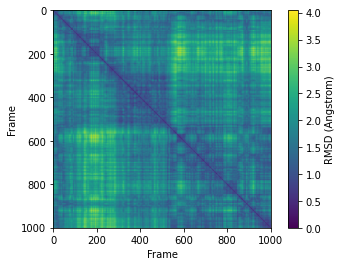

In [36]:
#Here we plot the Monomer RMSD matrix
plt.imshow(matrix1.results.dist_matrix, cmap='viridis')
plt.xlabel('Frame')
plt.ylabel('Frame')
plt.colorbar(label='RMSD (Angstrom)')


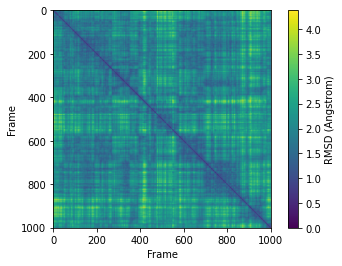

In [37]:
#Here we plot the Dimer RMSD matrix
plt.imshow(matrix2.results.dist_matrix, cmap='viridis')
plt.xlabel('Frame')
plt.ylabel('Frame')
plt.colorbar(label='RMSD (Angstrom)')

##Part II – Principal Component Analysis

###II.1 - Principal Component Analysis  

In [45]:
#Import things
import MDAnalysis as mda
from MDAnalysis.analysis import diffusionmap, align
import matplotlib.pyplot as plt
%matplotlib inline

**WARNING!!!**

For best results, your trajectory should be aligned on your atom group selection before you run the analysis. Setting align=True will not give correct results in the PCA.

In [46]:
# Align the trajectory 
aligner1 = align.AlignTraj(monomer_mobile, monomer_mobile, select='backbone', in_memory=True).run()
aligner2 = align.AlignTraj(dimer_mobile, dimer_mobile, select='backbone', in_memory=True).run()


####Overview of the method
**Principal component analysis (PCA)** is a statistical technique that decomposes a system of observations into linearly uncorrelated variables called principal components. These components are ordered so that the first principal component accounts for the largest variance in the data, and each following component accounts for lower and lower variance. PCA is often applied to molecular dynamics trajectories to **extract the large-scale conformational motions or “essential dynamics” of a protein**. The frame-by-frame conformational fluctuation can be considered a linear combination of the essential dynamics yielded by the PCA.

In MDAnalysis, the method is as follows:

> Optionally align each frame in your trajectory to the first frame.
Construct a 3N x 3N covariance for the N atoms in your trajectory. Optionally, you can provide a mean; otherwise the covariance is to the averaged structure over the trajectory.
Diagonalise the covariance matrix. The eigenvectors are the principal components, and their eigenvalues are the associated variance.
Sort the eigenvalues so that the principal components are ordered by variance.



In [47]:
import MDAnalysis as mda
import MDAnalysis.analysis.pca as pca
from MDAnalysis.coordinates.base import Timestep

import numpy as np
import os
import glob

import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.cm
import matplotlib.ticker as ticker
%matplotlib inline

#### Call the PCA function
You can choose how many principal components to save from the analysis with n_components. The default value is None, which saves all of them. You can also pass a mean reference structure to be used in calculating the covariance matrix. With the default value of None, the covariance uses the mean coordinates of the trajectory.

In [48]:
pcu1 = pca.PCA(monomer_mobile, select='protein and backbone',
             align=False, mean=None,
             n_components=None).run()
pcu2 = pca.PCA(dimer_mobile, select='protein and backbone',
             align=False, mean=None,
             n_components=None).run()


#### The principal components are saved in pc.p_components. 
If you kept all the components, you should have an array of shape (natoms×3,natoms×3)


In [49]:
backbone1 = monomer_mobile.select_atoms('protein and backbone')
n_bb1 = len(backbone1)
print('There are {} backbone atoms in the analysis'.format(n_bb1))
print(pcu1.p_components.shape)

backbone2 = dimer_mobile.select_atoms('protein and backbone')
n_bb2 = len(backbone2)
print('There are {} backbone atoms in the analysis'.format(n_bb2))
print(pcu2.p_components.shape)

There are 207 backbone atoms in the analysis
(621, 621)
There are 414 backbone atoms in the analysis
(1242, 1242)


/usr/local/lib/python3.7/dist-packages/MDAnalysis/analysis/pca.py:321: DeprecationWarning:

The `p_components` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.p_components` instead.



#### Get the variance of the first component

In [50]:
pcu1.variance[0],pcu2.variance[0]

/usr/local/lib/python3.7/dist-packages/MDAnalysis/analysis/pca.py:329: DeprecationWarning:

The `variance` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.variance` instead.



(133.50120832311453, 202.467056957568)

This variance is somewhat meaningless by itself. It is much more intuitive to consider the variance of a principal component as a percentage of the total variance in the data. MDAnalysis also tracks the percentage cumulative variance in pc.cumulated_variance. As shown below, the first principal component contains 90.3% the total trajectory variance. The first three components combined account for 96.4% of the total variance.

In [51]:
print(pcu1.cumulated_variance[0])
print(pcu1.cumulated_variance[2])
print(pcu2.cumulated_variance[0])
print(pcu2.cumulated_variance[2])

0.3724331942855606
0.655739556396987
0.21745256710442898
0.5128336307790156


/usr/local/lib/python3.7/dist-packages/MDAnalysis/analysis/pca.py:337: DeprecationWarning:

The `cumulated_variance` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.cumulated_variance` instead.



/usr/local/lib/python3.7/dist-packages/MDAnalysis/analysis/pca.py:337: DeprecationWarning:

The `cumulated_variance` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.cumulated_variance` instead.



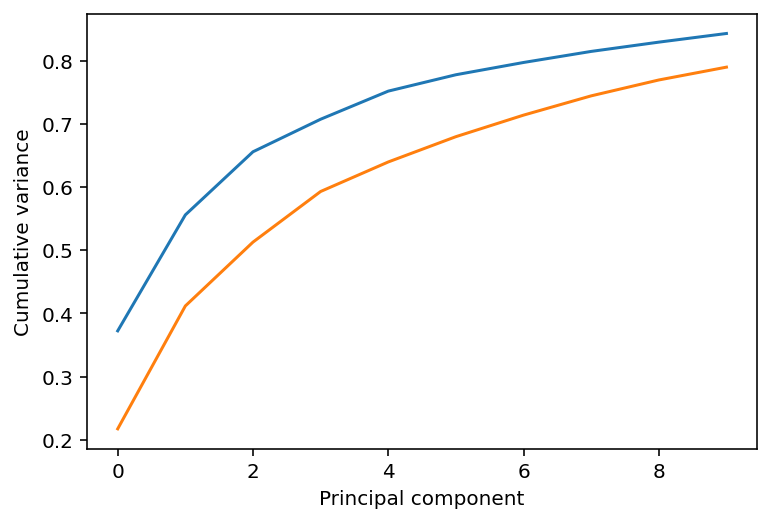

In [52]:
plt.plot(pcu1.cumulated_variance[:10])
plt.xlabel('Principal component')
plt.ylabel('Cumulative variance');

plt.plot(pcu2.cumulated_variance[:10])
plt.xlabel('Principal component')
plt.ylabel('Cumulative variance');

#### Visualising projections into a reduced dimensional space

The pc.transform() method transforms a given atom group into weights $w_i$
 over each principal component $i$
.

$w_i(t)=(r(t)−r⎯⎯⎯)⋅u_i$

$r(t)$
 are the atom group coordinates at time t
, r⎯⎯⎯
 are the mean coordinates used in the PCA, and ui
 is the i
th principal component eigenvector u
.

While the given atom group must have the same number of atoms that the principal components were calculated over, it does not have to be the same group.

Again, passing n_components=None will tranform your atom group over every component. Below, we limit the output to projections over 5 principal components only.

In [53]:
transformed1 = pcu1.transform(backbone1, n_components=5)


transformed2 = pcu2.transform(backbone2, n_components=5)
transformed1.shape, transformed2.shape

((1001, 5), (1001, 5))

The output has the shape (n_frames, n_components). For easier analysis and plotting we can turn the array into a DataFrame.

In [54]:
df1 = pd.DataFrame(transformed1,
                  columns=['PC{}'.format(i+1) for i in range(5)])
df1['Time (ns)'] = df1.index * monomer_mobile.trajectory.dt
df1.head()

df2 = pd.DataFrame(transformed2,
                  columns=['PC{}'.format(i+1) for i in range(5)])
df2['Time (ns)'] = df2.index * dimer_mobile.trajectory.dt
df2.head()

,PC1,PC2,PC3,PC4,PC5,Time (ns)
0,21.480540,-3.706072,-2.371539,-13.204921,7.259158,0.0
1,27.619437,-4.624983,-1.979699,-11.631938,4.005924,20.0
2,28.172972,-5.266845,-0.769116,-20.944526,3.206870,40.0
3,26.798816,-1.862034,-1.760498,-18.470935,7.192493,60.0
4,27.219181,-15.385852,5.773278,-19.311702,3.468134,80.0


There are several ways we can visualise the data. Using the Seaborn’s PairGrid tool is the quickest and easiest way, if you have seaborn already installed.

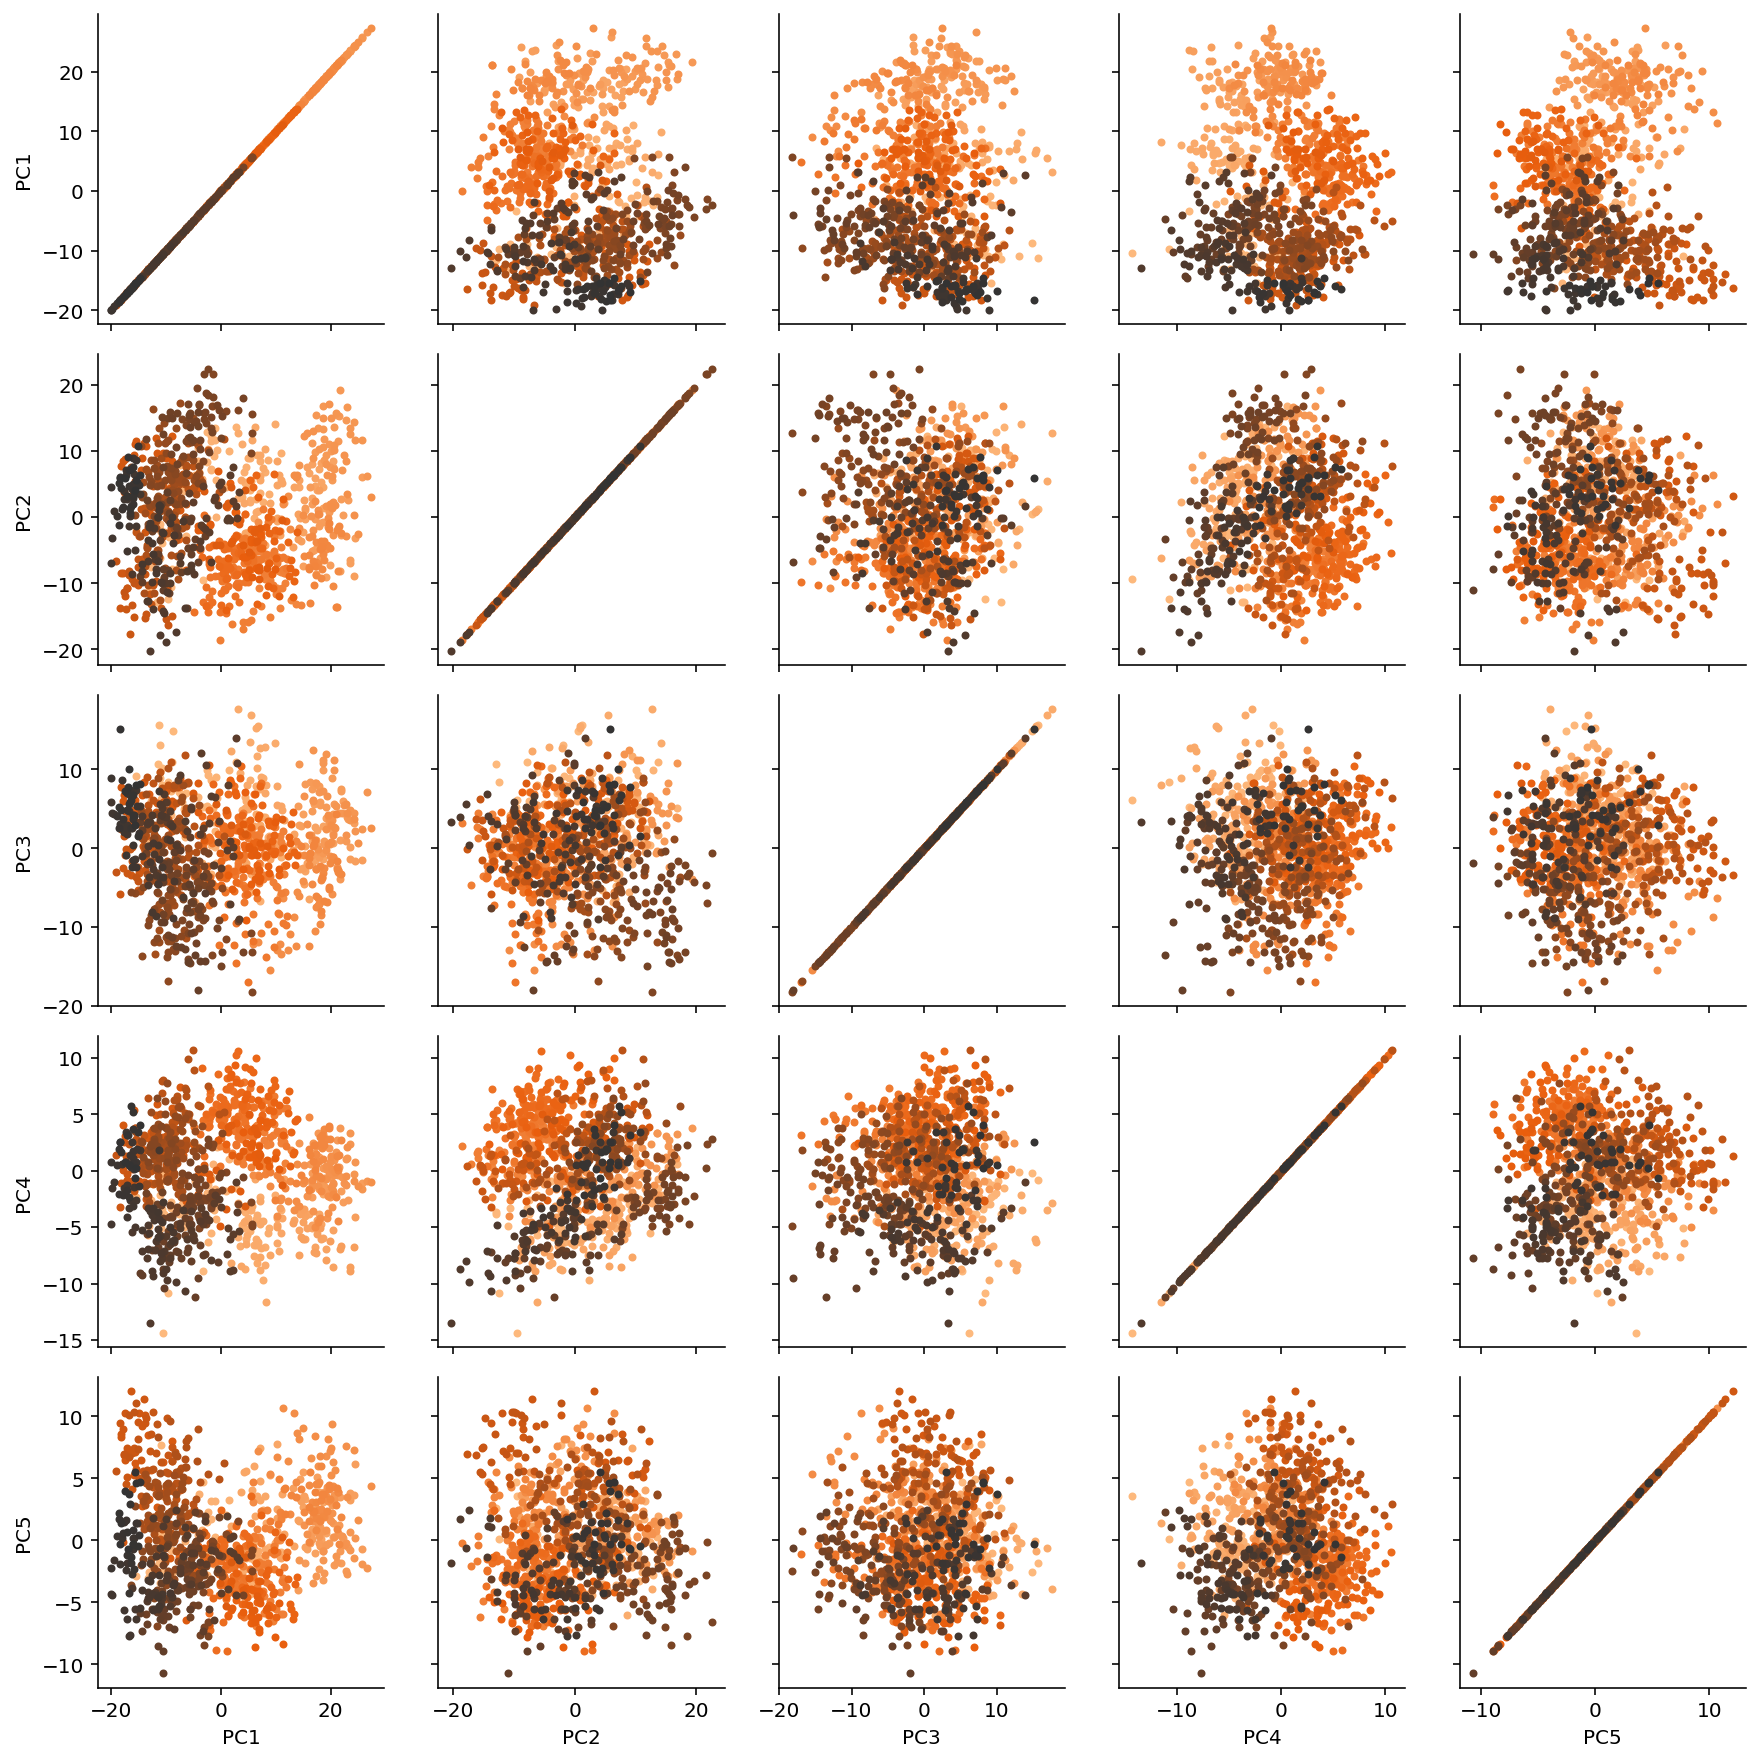

In [55]:
import seaborn as sns

g1 = sns.PairGrid(df1, hue='Time (ns)',
                 palette=sns.color_palette('Oranges_d',
                                           n_colors=len(df1)))
g1.map(plt.scatter, marker='.')

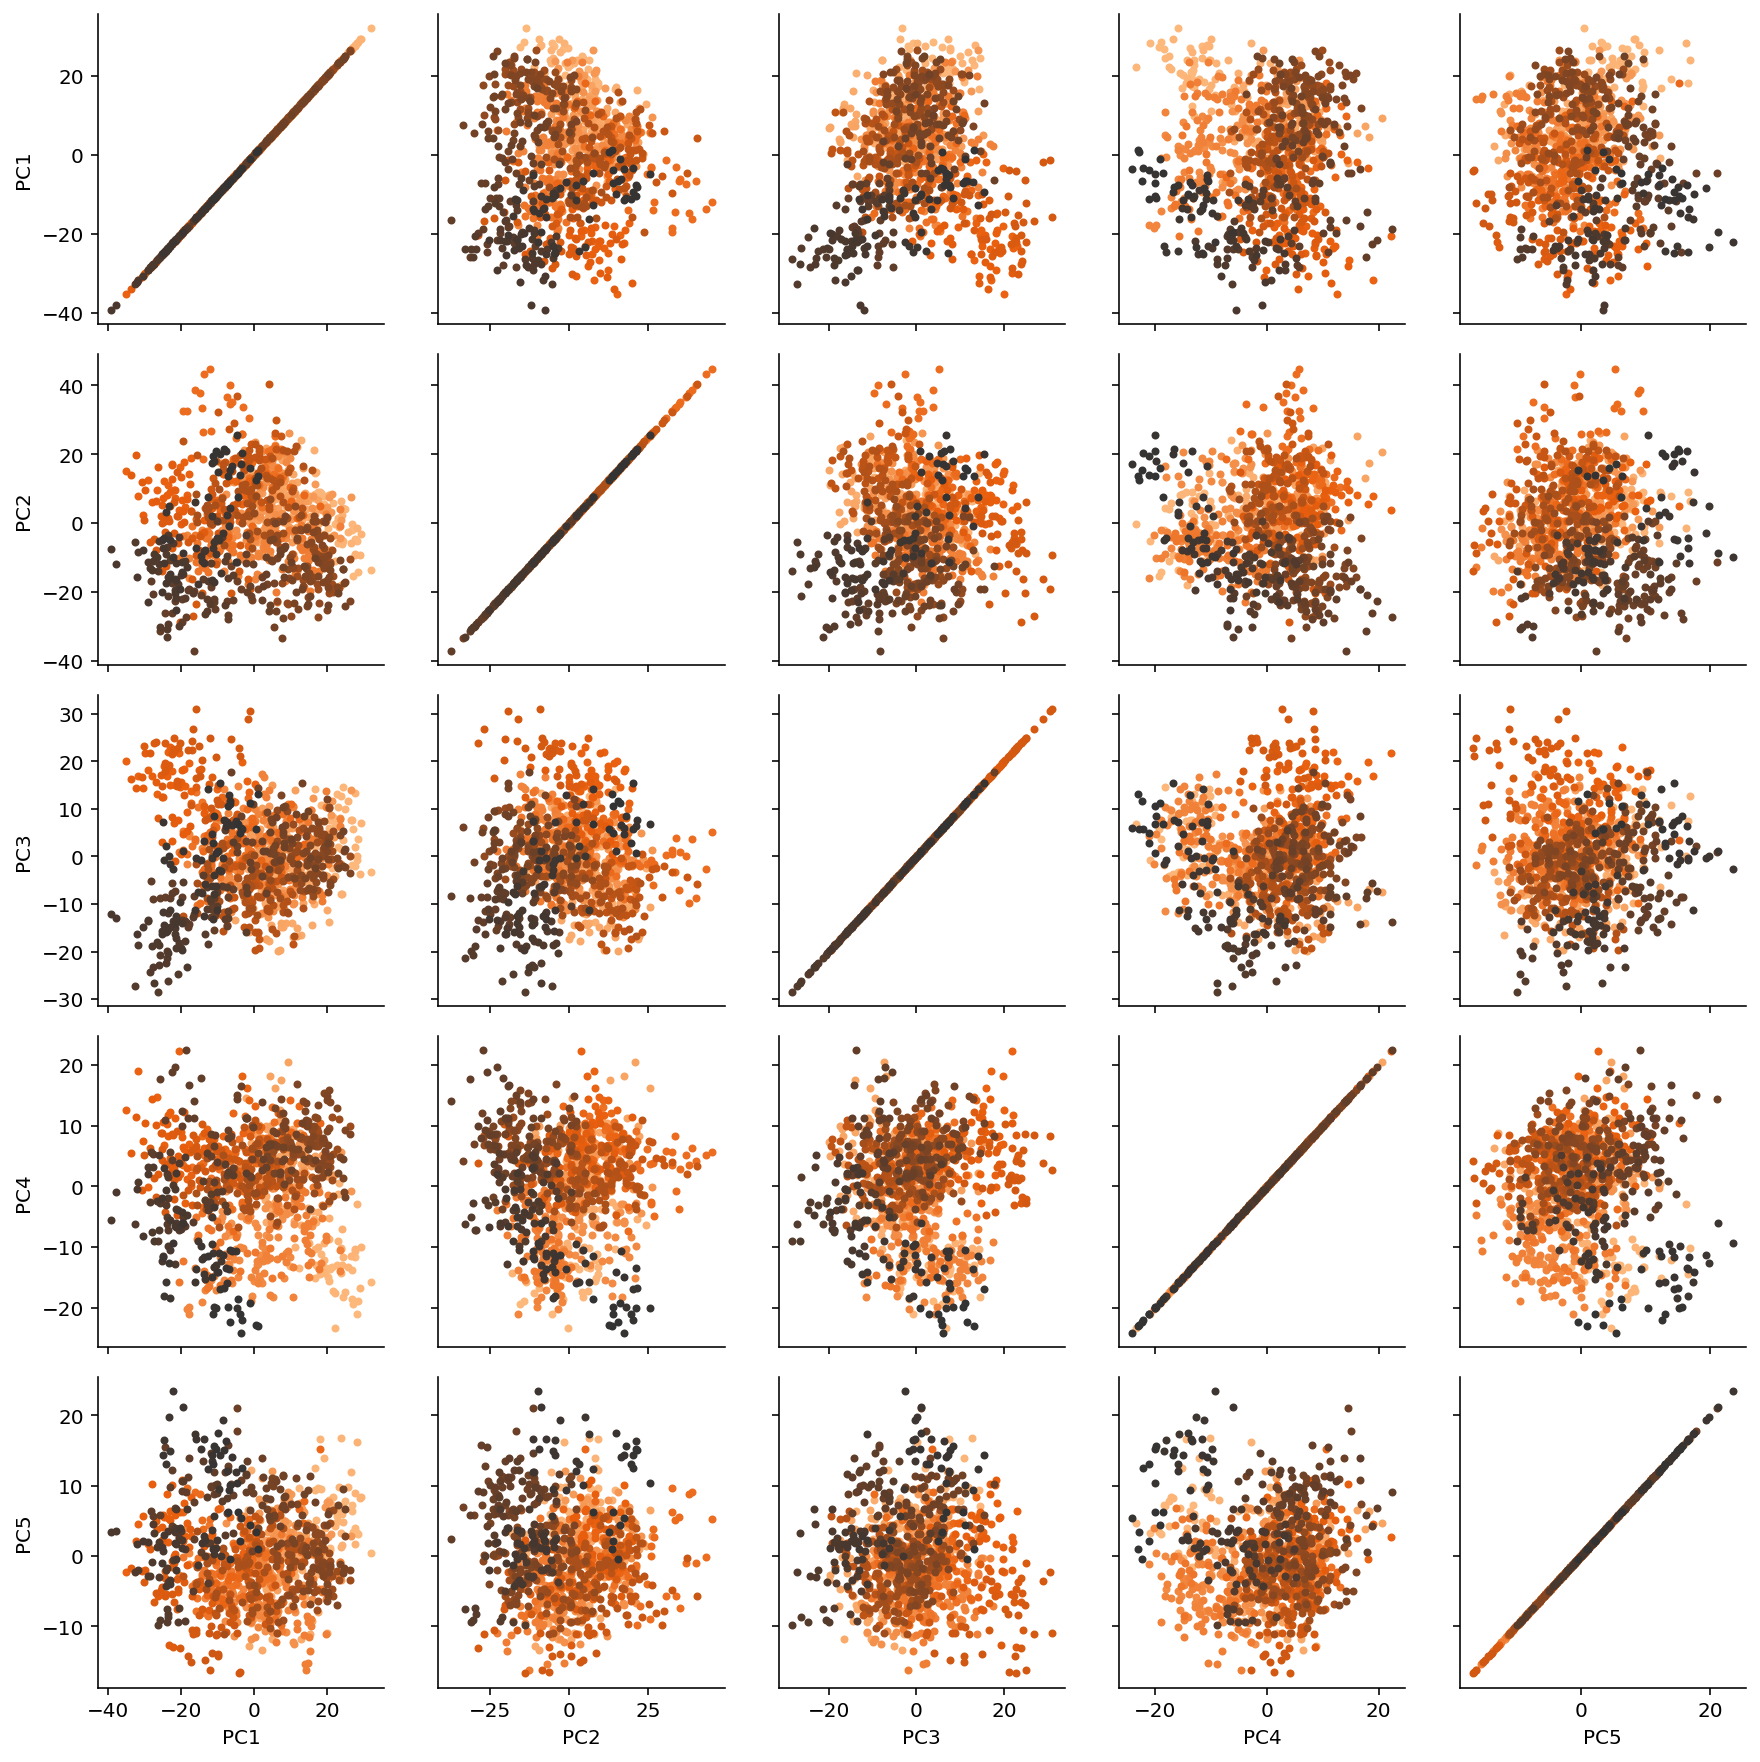

In [56]:
g2 = sns.PairGrid(df2, hue='Time (ns)',
                 palette=sns.color_palette('Oranges_d',
                                           n_colors=len(df2)))
g2.map(plt.scatter, marker='.')

Another way to investigate the essential motions of the trajectory is to project the original trajectory onto each of the principal components, to visualise the motion of the principal component. The product of the weights $w_i(t)$
 for principal component $_i$
 with the eigenvector $u_i$
 describes fluctuations around the mean on that axis, so the projected trajectory $r_i(t)$
 is simply the fluctuations added onto the mean positions r⎯⎯⎯
.

$r_i(t)=w_i(t)×u_i+r$
Below, we generate the projected coordinates of the first principal component. The mean positions are stored at pc.mean.

In [57]:
pc1u1 = pcu1.p_components[:, 0]
trans1u1 = transformed1[:, 0]
projectedu1 = np.outer(trans1u1, pc1u1) 
coordinatesu1 = projectedu1.reshape(len(trans1u1), -1, 3) + pcu1.mean

pc1u2 = pcu2.p_components[:, 0]
trans1u2 = transformed2[:, 0]
projectedu2 = np.outer(trans1u2, pc1u2) 
coordinatesu2 = projectedu2.reshape(len(trans1u2), -1, 3) - pcu2.mean

/usr/local/lib/python3.7/dist-packages/MDAnalysis/analysis/pca.py:321: DeprecationWarning:

The `p_components` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.p_components` instead.



We can create a new universe from this to visualise the movement over the first principal component.

In [58]:
!pip3 install nglview
import nglview as nv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.7 MB 5.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.6 MB 50.3 MB/s 
  Created wheel for nglview: filename=nglview-3.0.3-py3-none-any.whl size=8057551 sha256=7a16eeba38f0ab4e968a1242fcc0e99338f925788363831a0df6e0c7a5bab545
  Stored in directory: /root/.cache/pip/wheels/01/0c/49/c6f79d8edba8fe89752bf20de2d99040bfa57db0548975c5d5
Successfully built nglview


In [59]:
proj1 = mda.Merge(backbone2)
proj1.load_new(coordinatesu2, order="fac")

<Universe with 414 atoms>

In [60]:
view = nv.show_mdanalysis(proj1.atoms)
view

NGLWidget(max_frame=1000)

In [61]:
from google.colab import output
output.enable_custom_widget_manager()

In [62]:
from google.colab import output
output.disable_custom_widget_manager()

If you have nglview installed, you can view the trajectory in the notebook. Otherwise, you can write the trajectory out to a file and use another program such as VMD. Below, we create a movie of the component.

In [63]:
!pip install moviepy==0.2.2.11
!pip install imageio==1.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 107 kB 5.5 MB/s 
  Created wheel for moviepy: filename=moviepy-0.2.2.11-py3-none-any.whl size=102396 sha256=712e0868ec1f4a38561d504b8cdfbf4c7eaab784957df2f49f74bf6aea233678
  Stored in directory: /root/.cache/pip/wheels/97/98/9c/9a41bf6ab0d9eab6bd656f532acd43a678347d5de4b1ea6316
Successfully built moviepy
  Attempting uninstall: moviepy
    Found existing installation: moviepy 0.2.3.5
    Uninstalling moviepy-0.2.3.5:
      Successfully uninstalled moviepy-0.2.3.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.3 MB 1.7 MB/s 
  Created wheel for imageio: filename=imageio-1.6-py3-none-any.whl size=3224565 sha256=6b1864b3563004592595fea43ef1ed2111586f8a10c5fcafb4881618242cd0dc
  Stored in directory: /root/.cache/pip/wheels/ea/aa/dc/55ade60fd9491394f2896bbc3cc8

In [65]:
from nglview.contrib.movie import MovieMaker
movie = MovieMaker(view, output='pc1u1.gif', in_memory=True)
movie.make()

IntProgress(value=0, description='Rendering ...', max=1000)